In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#For Prediction
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm
from sklearn.svm import SVR
from sklearn import metrics

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# Read Datasets 
hist = pd.read_csv('Datasets/gemini_BTCUSD_1hr_mod.csv')
hist.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1559433600000,2019-06-02 00:00:00,BTCUSD,8566.10,8567.20,8546.38,8567.20,0.899330
1,1559430000000,2019-06-01 23:00:00,BTCUSD,8587.25,8598.10,8527.58,8566.10,156.493022
2,1559426400000,2019-06-01 22:00:00,BTCUSD,8598.89,8604.16,8542.44,8587.25,11.841891
3,1559422800000,2019-06-01 21:00:00,BTCUSD,8543.90,8609.96,8541.67,8598.89,18.957024
4,1559419200000,2019-06-01 20:00:00,BTCUSD,8538.75,8569.69,8532.23,8543.90,18.051794


In [8]:
#hist = hist.drop(['high','low','open','volumefrom','volumeto'], axis=1)
hist = hist.drop(['Unix Timestamp','Date','Symbol','Open','High','Low','Volume'], axis=1)
hist.head()

,Close
0,8567.20
1,8566.10
2,8587.25
3,8598.89
4,8543.90


# Implementation 1

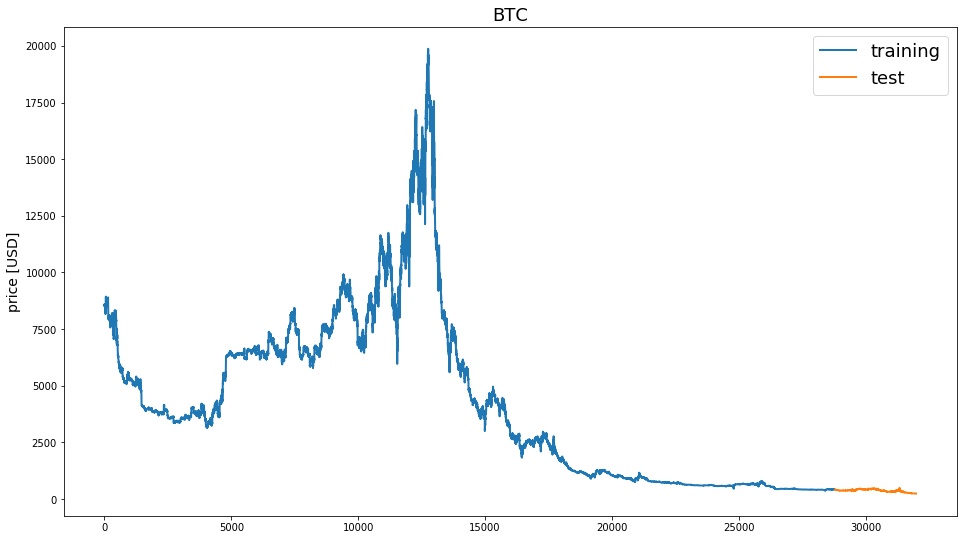

In [9]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.Close, test.Close, 'training', 'test', 'BTC')

In [10]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.Close[window:].values
    y_test = test_data.Close[window:].values
    if zero_base:
        y_train = y_train / train_data.Close[:-window].values - 1
        y_test = y_test / test_data.Close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [11]:
# NOT USED
# COULD GRAPH LINEAR KERNEL, BUT WOULD NEED TO PASS X WITH ONLY ONE FEATURE SO ITS SIZE MATCHES Y'S SIZE
def predict_prices(X, Y, X_test, X_forecast): 
    svr_lin  = SVR(kernel='linear', C=1e3) # best
    svr_poly = SVR(kernel='poly', C=1e3, degree=2) # too bad
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1) # good
     
    # Fit regression model
    svr_lin .fit(X, Y)
    svr_poly.fit(X, Y)
    svr_rbf.fit(X, Y)
    
    plt.scatter(X, Y, c='k', label='Whatever')
    plt.plot(X, svr_lin.predict(X), c='g', label='Linear model')
    plt.plot(X, svr_rbf.predict(X), c='r', label='RBF model')    
    plt.plot(X, svr_poly.predict(X), c='b', label='Polynomial model')
    
    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    
    return svr_rbf.predict(X_forecast)[0], svr_lin.predict(X_forecast)[0], svr_poly.predict(X_forecast)[0]

# predict_prices(X_train, y_train, X_test, X_forecast)

In [13]:
svr_lin = SVR(kernel='linear', C=1e3)
svr_lin.fit(X_train, y_train)

prediction_lin = svr_lin.predict(X_test)

print("The Explained Variance: %.2f" % svr_lin.score(X_test, y_test))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test, prediction_lin))  
print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test, prediction_lin)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test, prediction_lin)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test, prediction_lin))))

svr_lin.predict(X_forecast)[0]

(28775, 7, 1)
(28775,)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [149]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
svr_poly.fit(X_train, y_train)

prediction_poly = svr_poly.predict(X_test)

print("The Explained Variance: %.2f" % svr_poly.score(X_test, y_test))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test, prediction_poly))  
print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test, prediction_poly)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test, prediction_poly)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test, prediction_poly))))

svr_poly.predict(X_forecast)[0]

The Explained Variance: 0.65
The Mean Absolute Error: 1152.01
The Median Absolute Error: 194.60
The Mean Squared Error: 4606339.81
The Root Mean Squared Error: 2146.24


4133.209495380087

In [150]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)

prediction_rbf = svr_rbf.predict(X_test)

print("The Explained Variance: %.2f" % svr_rbf.score(X_test, y_test))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test, prediction_rbf))  
print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test, prediction_rbf)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test, prediction_rbf)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test, prediction_rbf))))

svr_rbf.predict(X_forecast)[0]

The Explained Variance: 0.98
The Mean Absolute Error: 149.49
The Median Absolute Error: 26.88
The Mean Squared Error: 313413.04
The Root Mean Squared Error: 559.83


6748.905153911851